## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

2025-10-05 12:37:45.588997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759667865.769276      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759667865.823981      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Assigning Path for Dataset

In [7]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [8]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [9]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

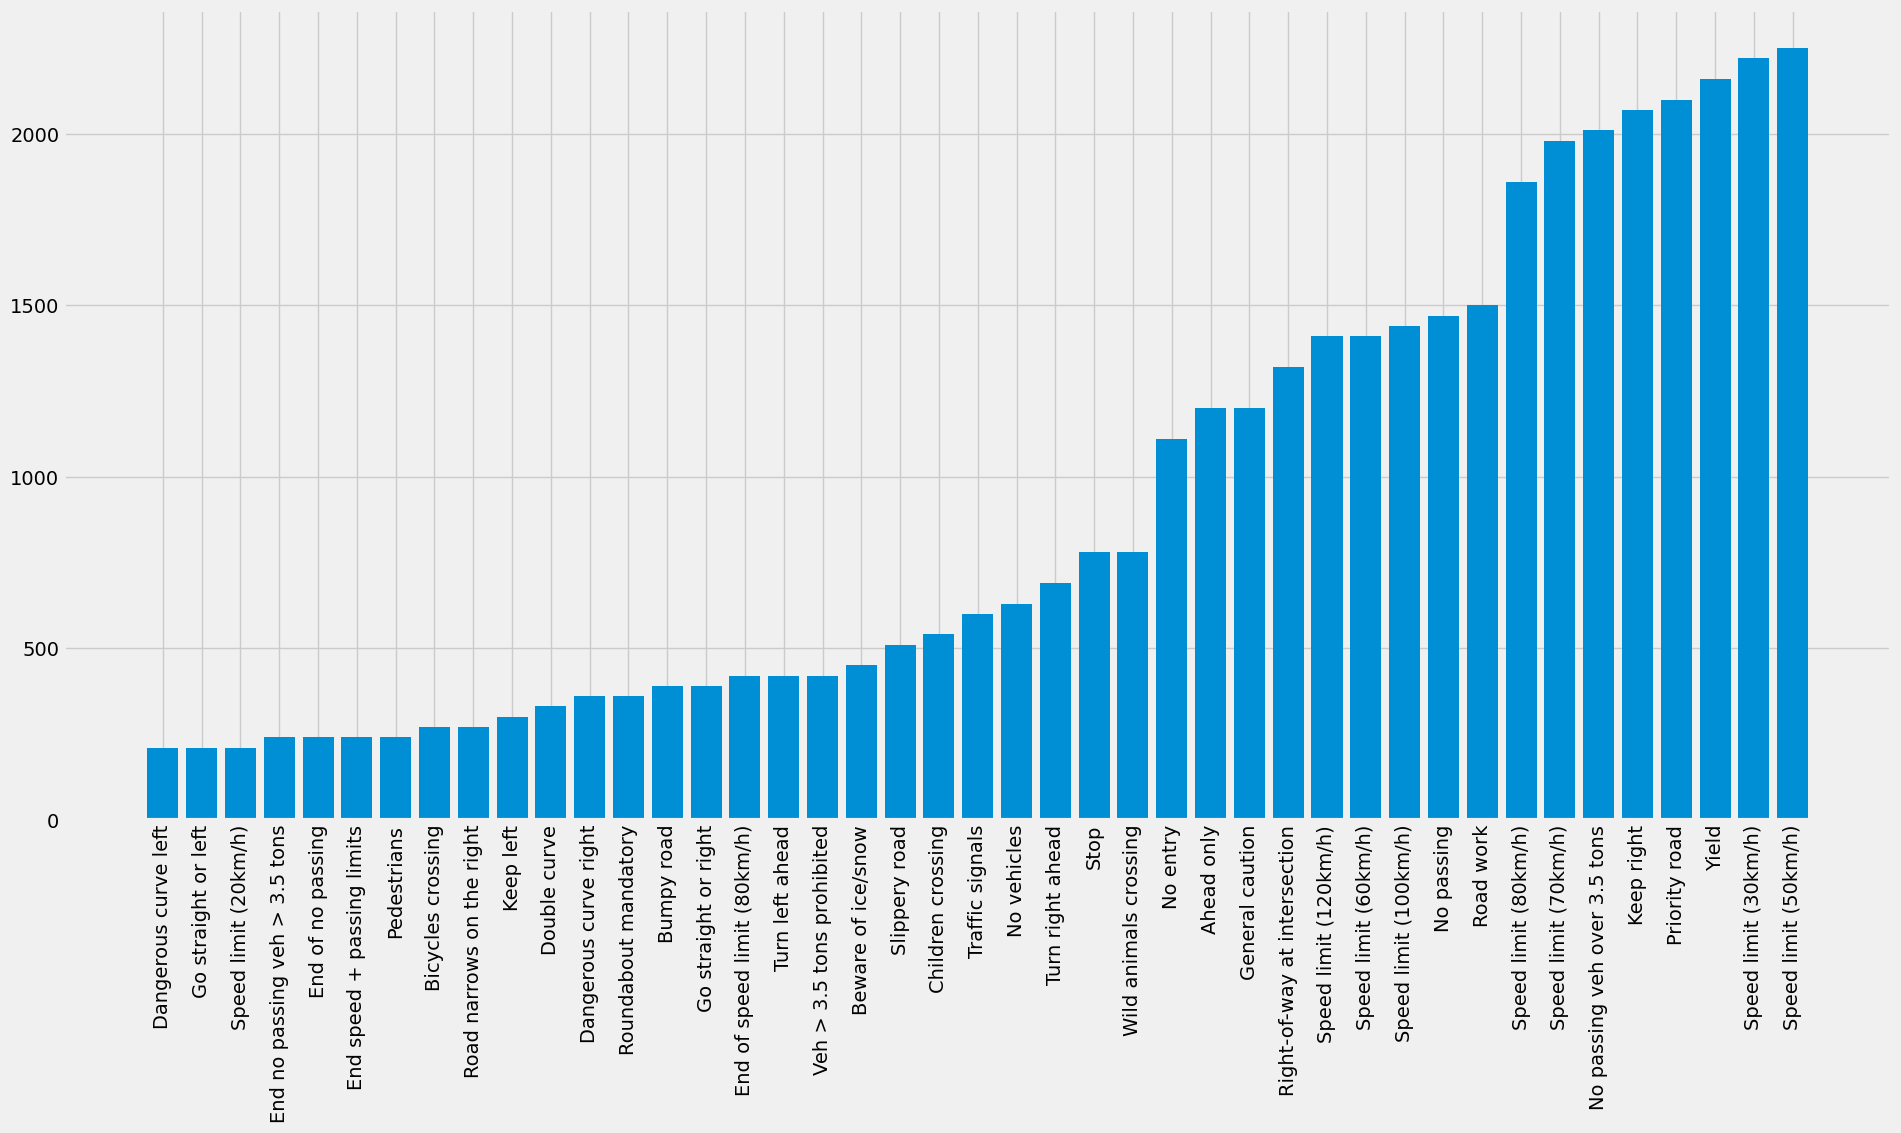

In [10]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

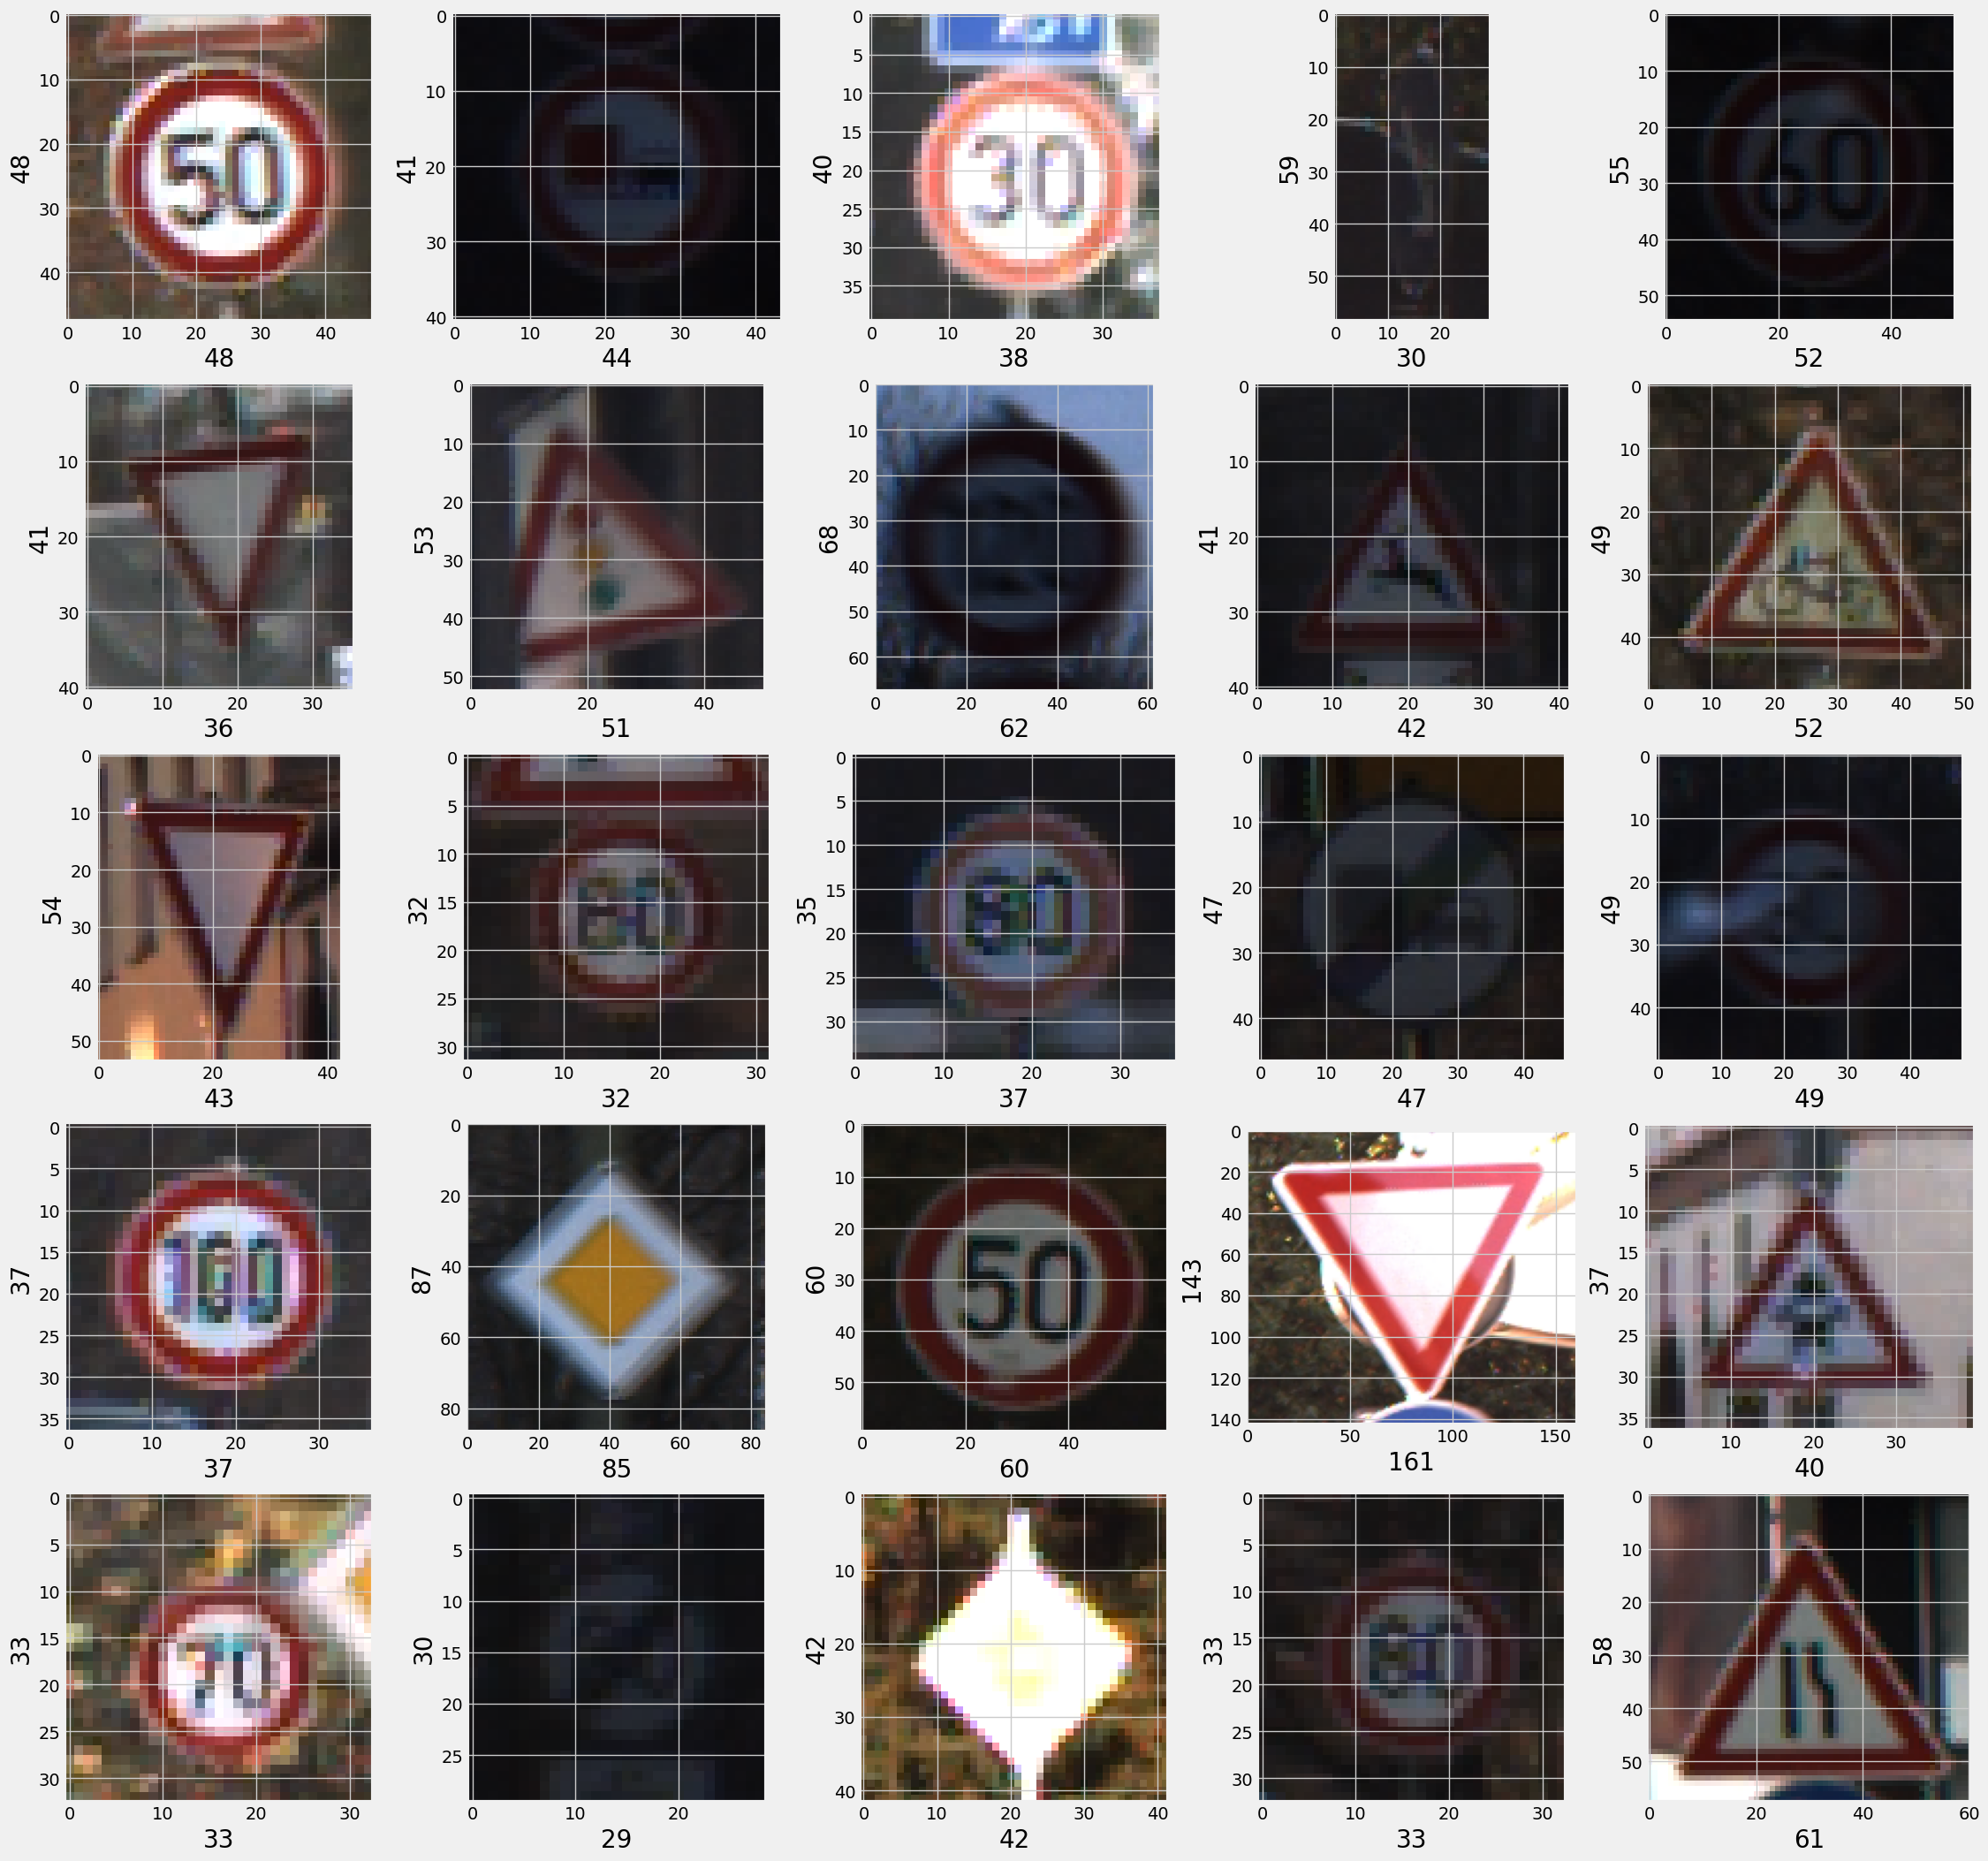

In [11]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [12]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []
error_count = 0
total_images = len(imgs)

print(f"Processing {total_images} test images...")

image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + '/' + str(i)
    images = os.listdir(path)
    for img in images:
        try:
            img_path = path + '/' + img
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to read image: {img_path}")
                continue
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(image_rgb)
            resize_image = pil_image.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except Exception as e:
            print(f"Error processing {img}: {str(e)}")
            continue

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(f"Processed {len(image_data)} training images successfully.")
print(f"Image data shape: {image_data.shape}, Labels shape: {image_labels.shape}")

Processing 12630 test images...
Processed 39209 training images successfully.
Image data shape: (39209, 30, 30, 3), Labels shape: (39209,)


## Shuffling the training data

In [13]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [14]:
print("image_data shape:", image_data.shape)
print("image_labels shape:", image_labels.shape)

if image_data.shape[0] == 0:
    print("No images loaded! Check your dataset path and image loading code.")
else:
    X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

    X_train = X_train/255 
    X_val = X_val/255

    print("X_train.shape", X_train.shape)
    print("X_valid.shape", X_val.shape)
    print("y_train.shape", y_train.shape)
    print("y_valid.shape", y_val.shape)

image_data shape: (39209, 30, 30, 3)
image_labels shape: (39209,)
X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [15]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [16]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759668240.689091      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [28]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

# Save the model in different formats for later use
# 1. Save the entire model (architecture + weights + optimizer state)
model.save('/kaggle/working/traffic_sign_classification.h5')

Epoch 1/30
  5/858 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 1.0000 - loss: 1.0260e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9980 - loss: 0.0064 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9982 - loss: 0.0050 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9995 - val_loss: 0.0013
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accurac

## Evaluating the model

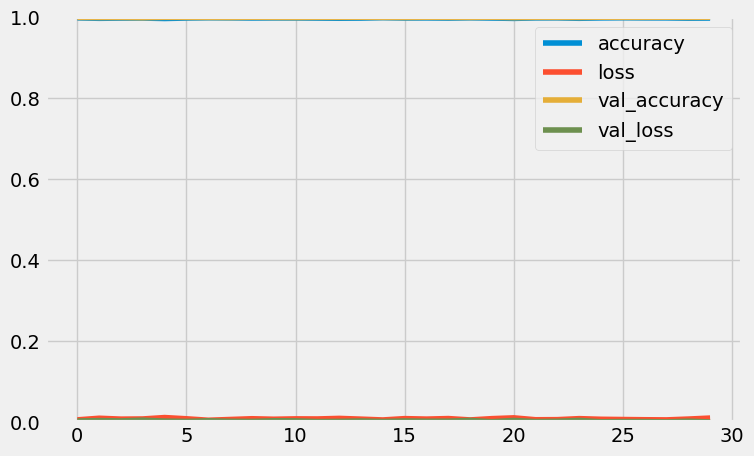

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [23]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predictions = model.predict(X_test)
pred = np.argmax(predictions, axis=1)

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Data accuracy:  81.70229612034838


## Visualizing the confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

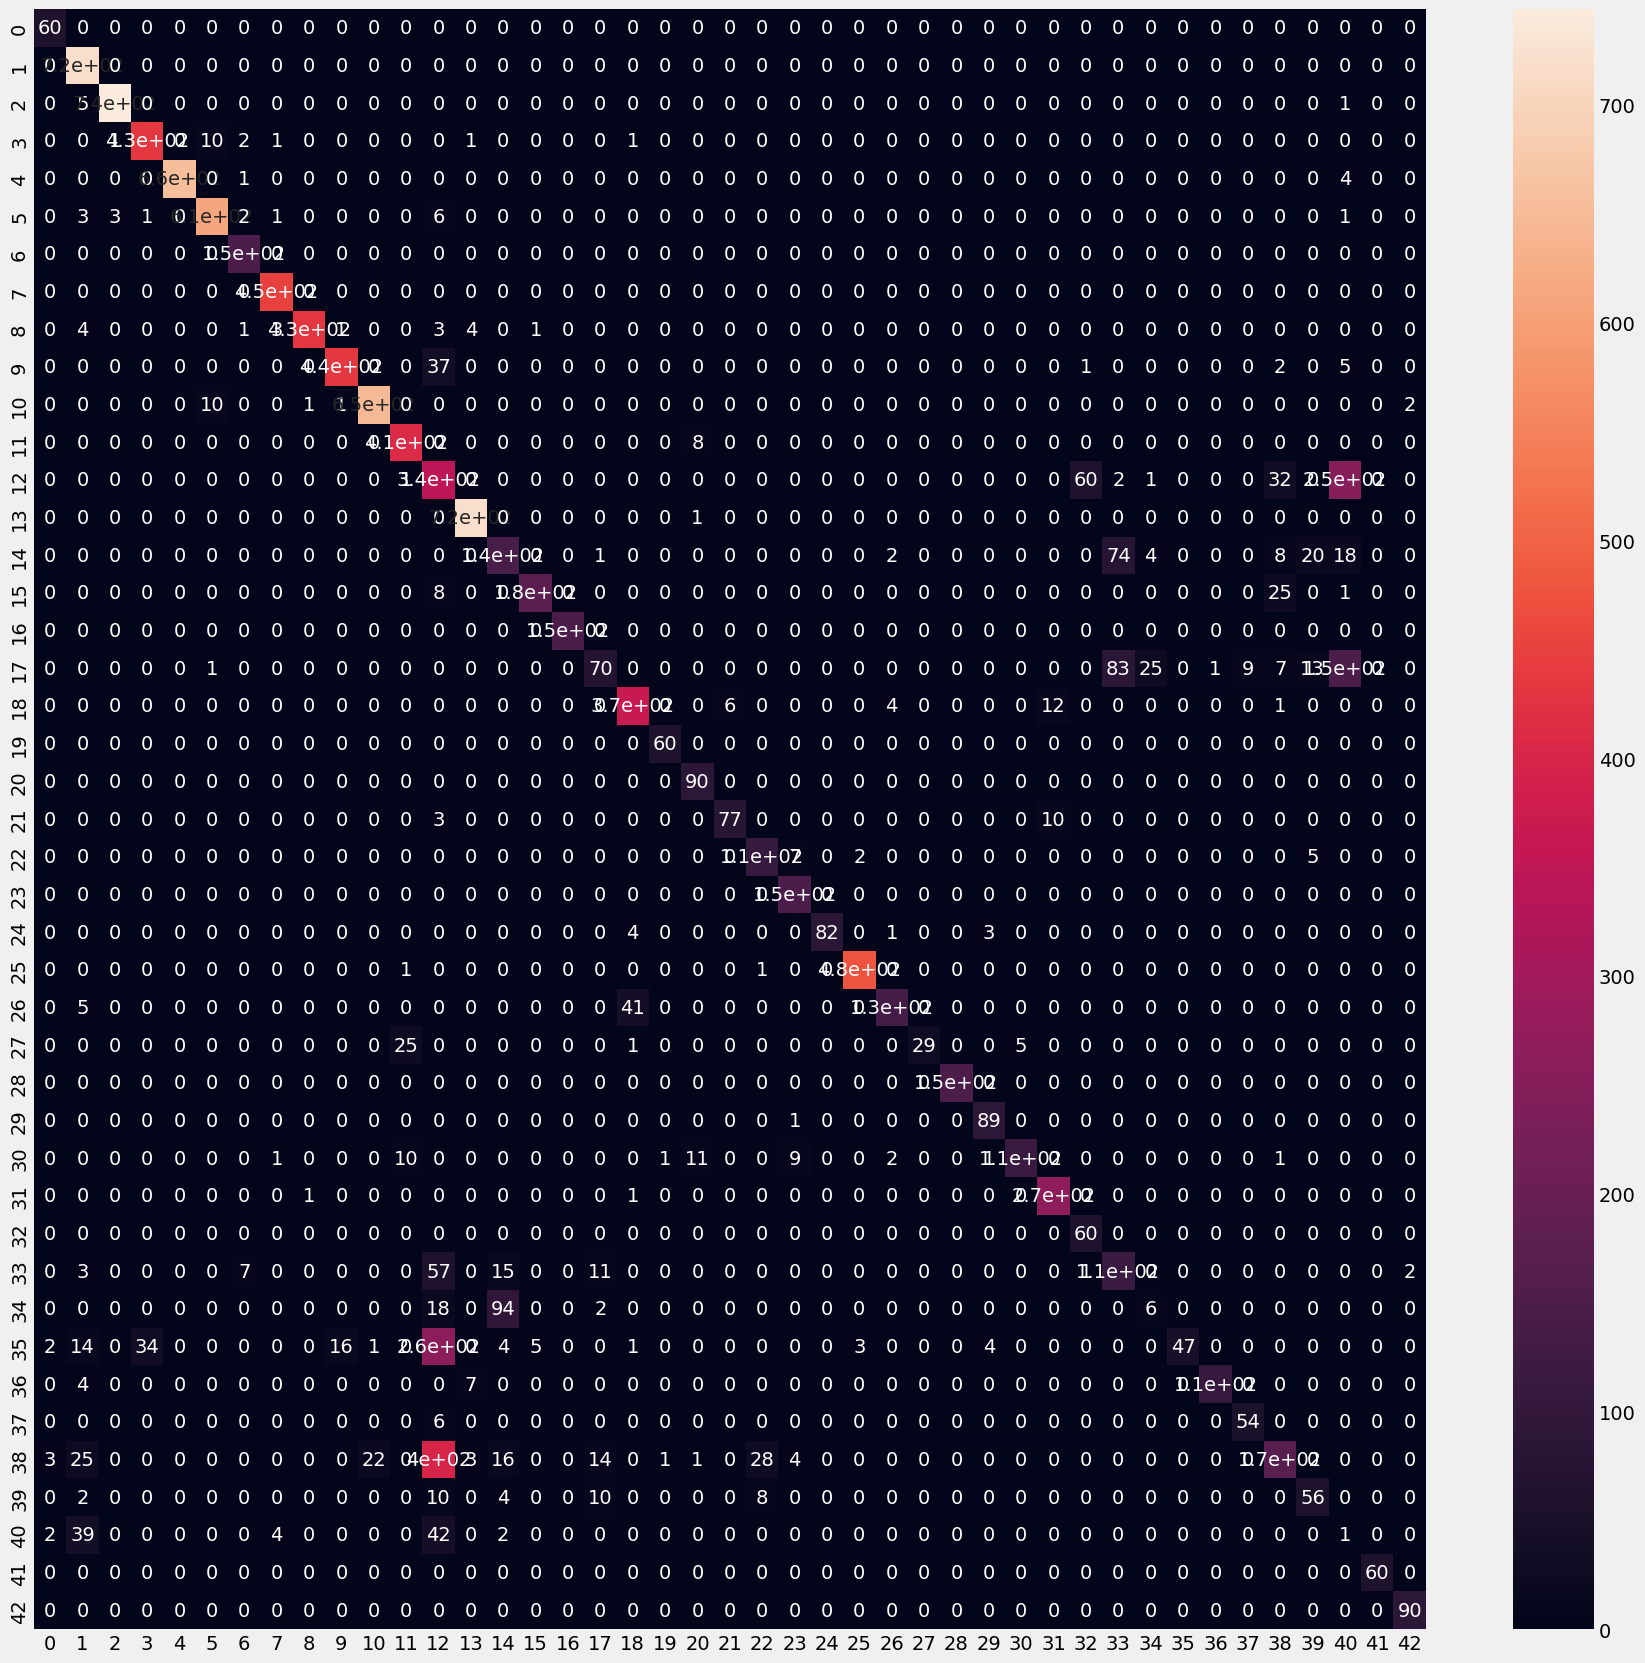

In [25]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [26]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94        60
           1       0.87      1.00      0.93       720
           2       0.99      0.99      0.99       750
           3       0.93      0.96      0.94       450
           4       1.00      0.99      1.00       660
           5       0.97      0.97      0.97       630
           6       0.92      1.00      0.96       150
           7       0.98      1.00      0.99       450
           8       1.00      0.96      0.98       450
           9       0.96      0.91      0.93       480
          10       0.97      0.98      0.97       660
          11       0.92      0.98      0.95       420
          12       0.29      0.50      0.37       690
          13       0.98      1.00      0.99       720
          14       0.51      0.53      0.52       270
          15       0.97      0.84      0.90       210
          16       1.00      1.00      1.00       150
          17       0.65    

## Predictions on Test Data

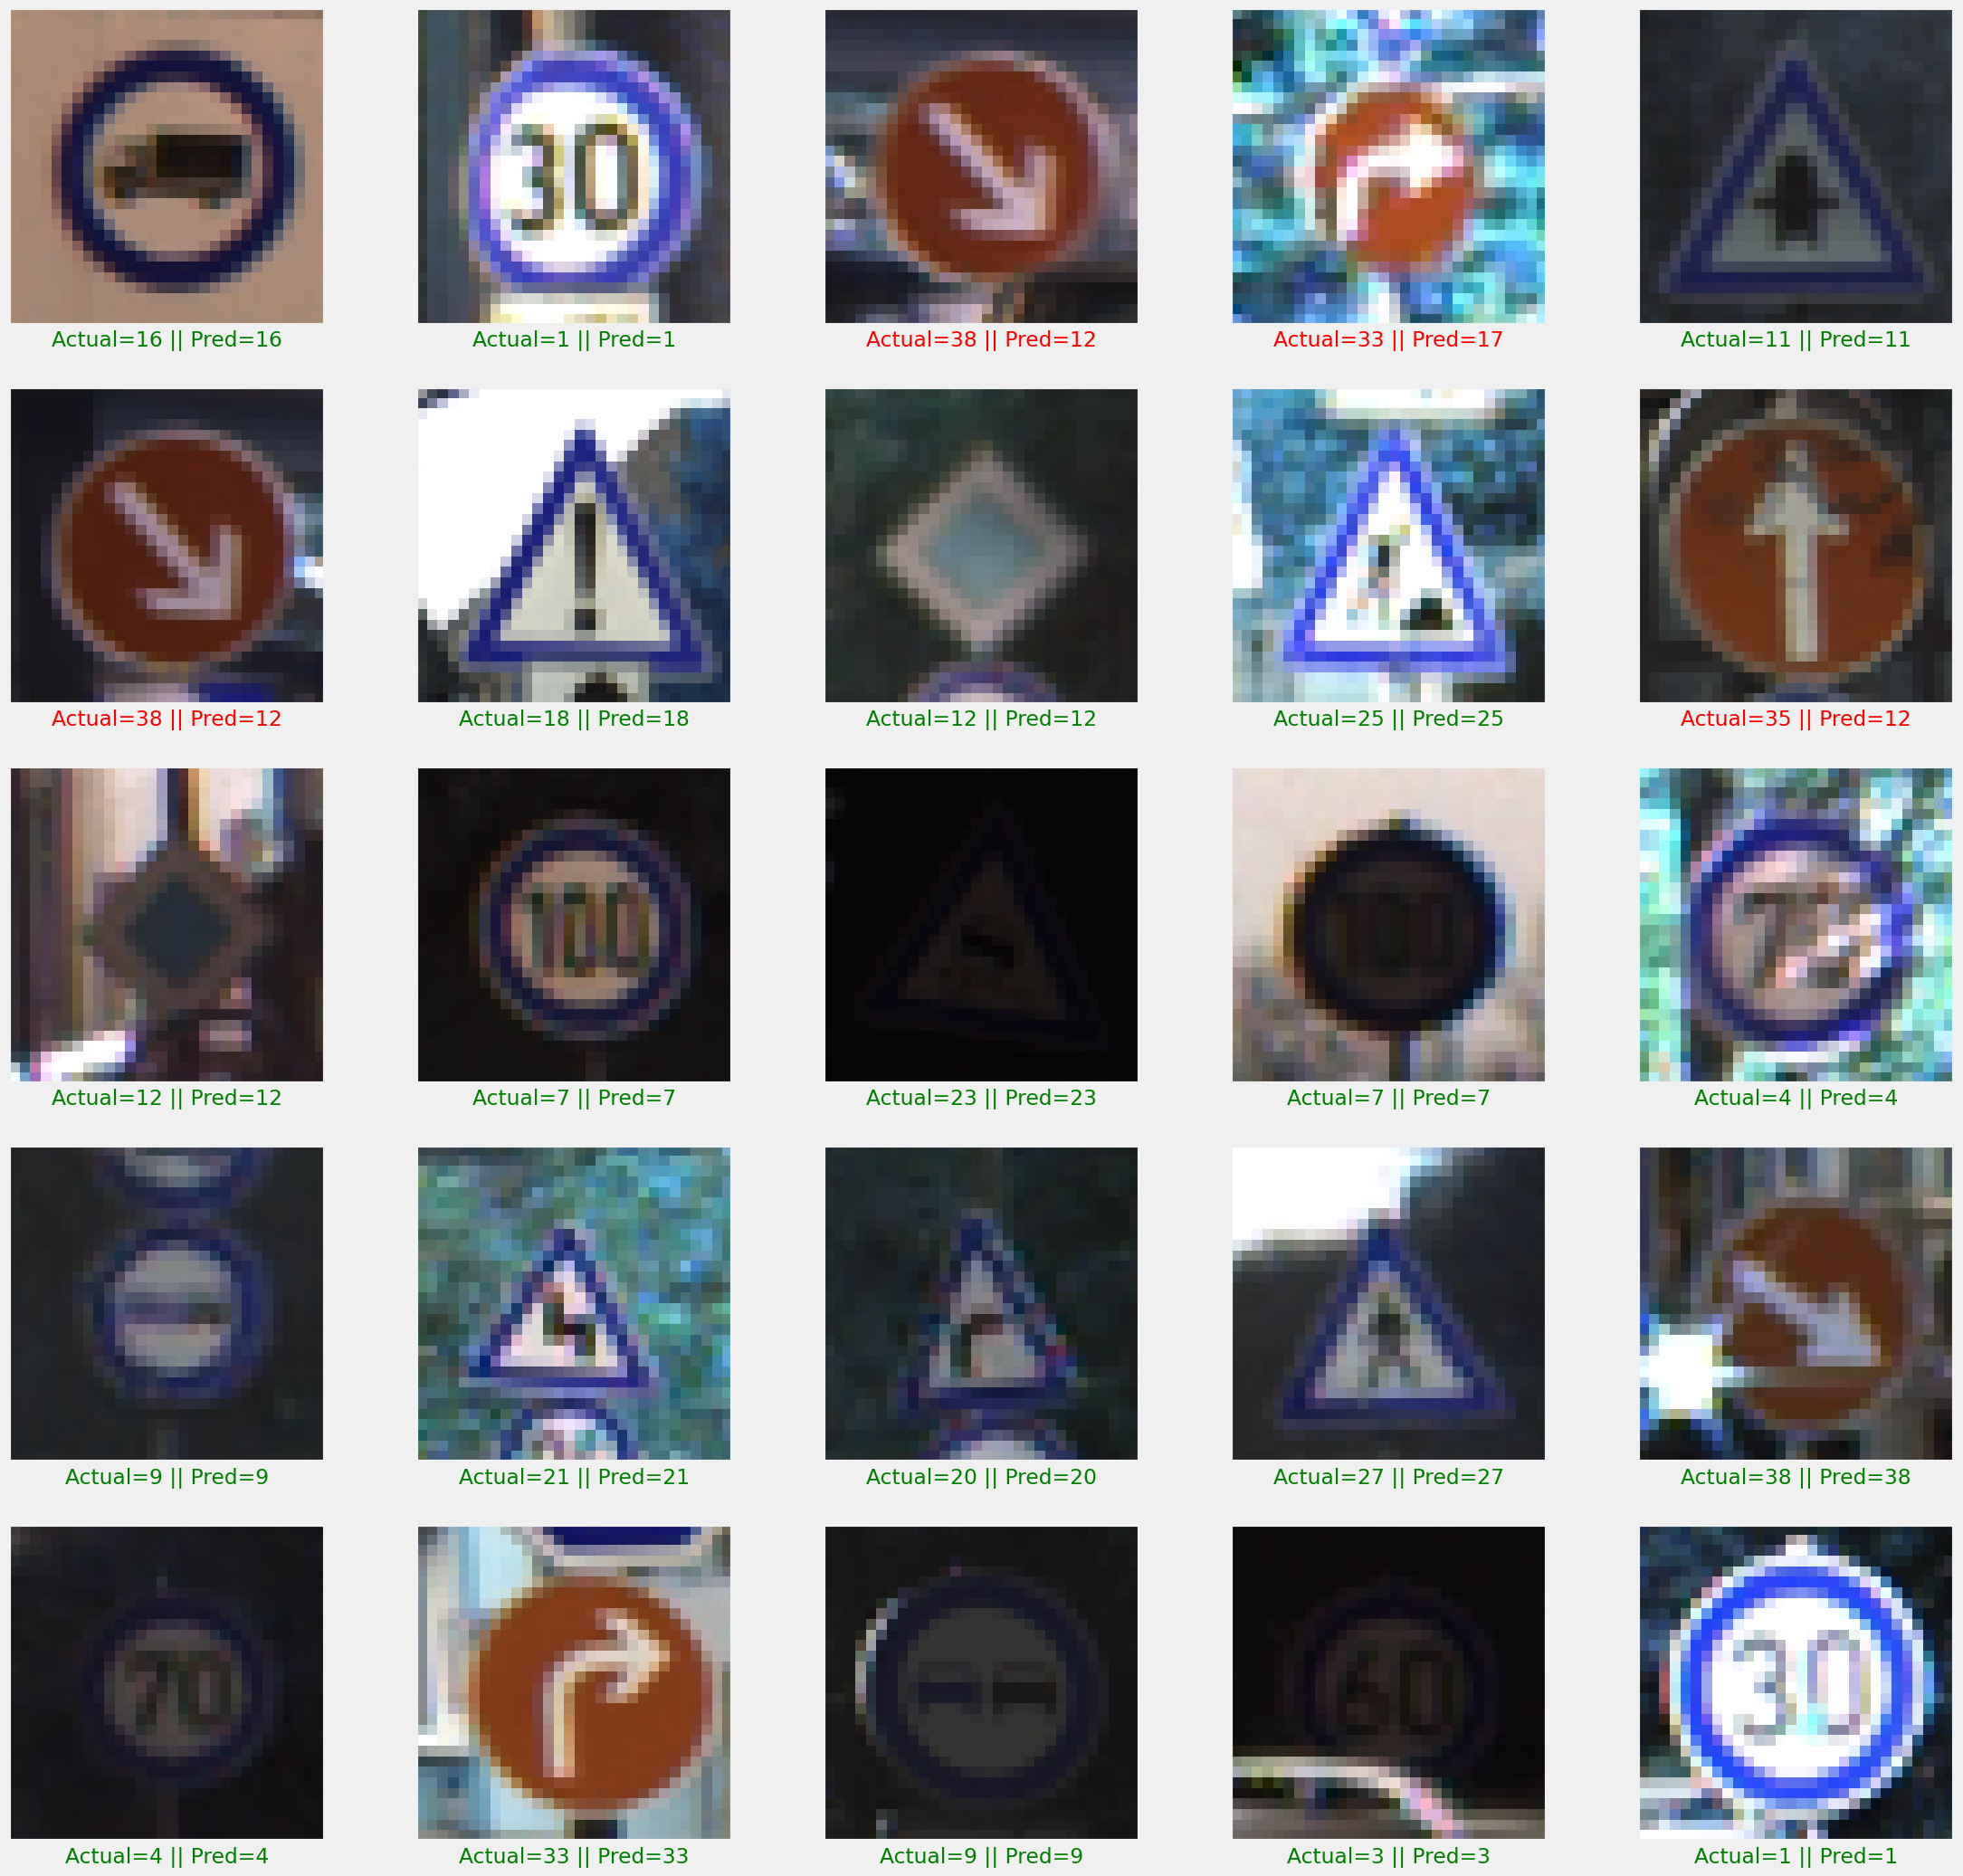

In [27]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
# How to load the saved model
from tensorflow.keras.models import load_model

# Method 1: Load the entire model (architecture + weights + optimizer state)
loaded_model = load_model('../../models/traffic_sign_classification.h5')

# Method 2: Load the model in TensorFlow SavedModel format
# loaded_model = tf.keras.models.load_model('../../models/traffic_sign_classification_saved_model')

# Verify the loaded model architecture
loaded_model.summary()

# Example prediction with the loaded model
def predict_traffic_sign(image_path):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((IMG_HEIGHT, IMG_WIDTH))
    img = np.array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Make prediction
    pred = loaded_model.predict(img)
    class_idx = np.argmax(pred, axis=1)[0]
    
    # Get confidence score
    confidence = np.max(pred) * 100
    
    return class_idx, confidence, classes[class_idx]